In [123]:
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
import geopandas as gp
from shapely.geometry import Point, Polygon

In [124]:
import CustomPipeline as cp
imputedHousingData=pd.read_csv("./data/predictedSalePrice.csv")
sns.set(rc={'figure.figsize':(14,10)})

In [125]:
shapefile = './location_mapping/Ames/Ames Precincts.shp'
df_neighbourhoods=gp.read_file(shapefile)
df_neighbourhoods
mappingData = pd.read_csv('./location_mapping/full_latlon.csv')
parkData = pd.read_csv('./location_mapping/AmesParksCoordinates.csv',header=None)

In [127]:
imputedHousingData_map = pd.merge(imputedHousingData, mappingData, on='PID')

array([[<AxesSubplot:title={'center':'Unnamed: 0'}>,
        <AxesSubplot:title={'center':'PID'}>,
        <AxesSubplot:title={'center':'GrLivArea'}>,
        <AxesSubplot:title={'center':'SalePrice'}>,
        <AxesSubplot:title={'center':'LotFrontage'}>,
        <AxesSubplot:title={'center':'LotArea'}>,
        <AxesSubplot:title={'center':'Alley'}>,
        <AxesSubplot:title={'center':'LotShape'}>,
        <AxesSubplot:title={'center':'Utilities'}>,
        <AxesSubplot:title={'center':'LandSlope'}>,
        <AxesSubplot:title={'center':'HouseStyle'}>,
        <AxesSubplot:title={'center':'OverallQual'}>,
        <AxesSubplot:title={'center':'OverallCond'}>],
       [<AxesSubplot:title={'center':'YearBuilt'}>,
        <AxesSubplot:title={'center':'YearRemodAdd'}>,
        <AxesSubplot:title={'center':'RoofStyle'}>,
        <AxesSubplot:title={'center':'RoofMatl'}>,
        <AxesSubplot:title={'center':'Exterior1st'}>,
        <AxesSubplot:title={'center':'Exterior2nd'}>,
        <A

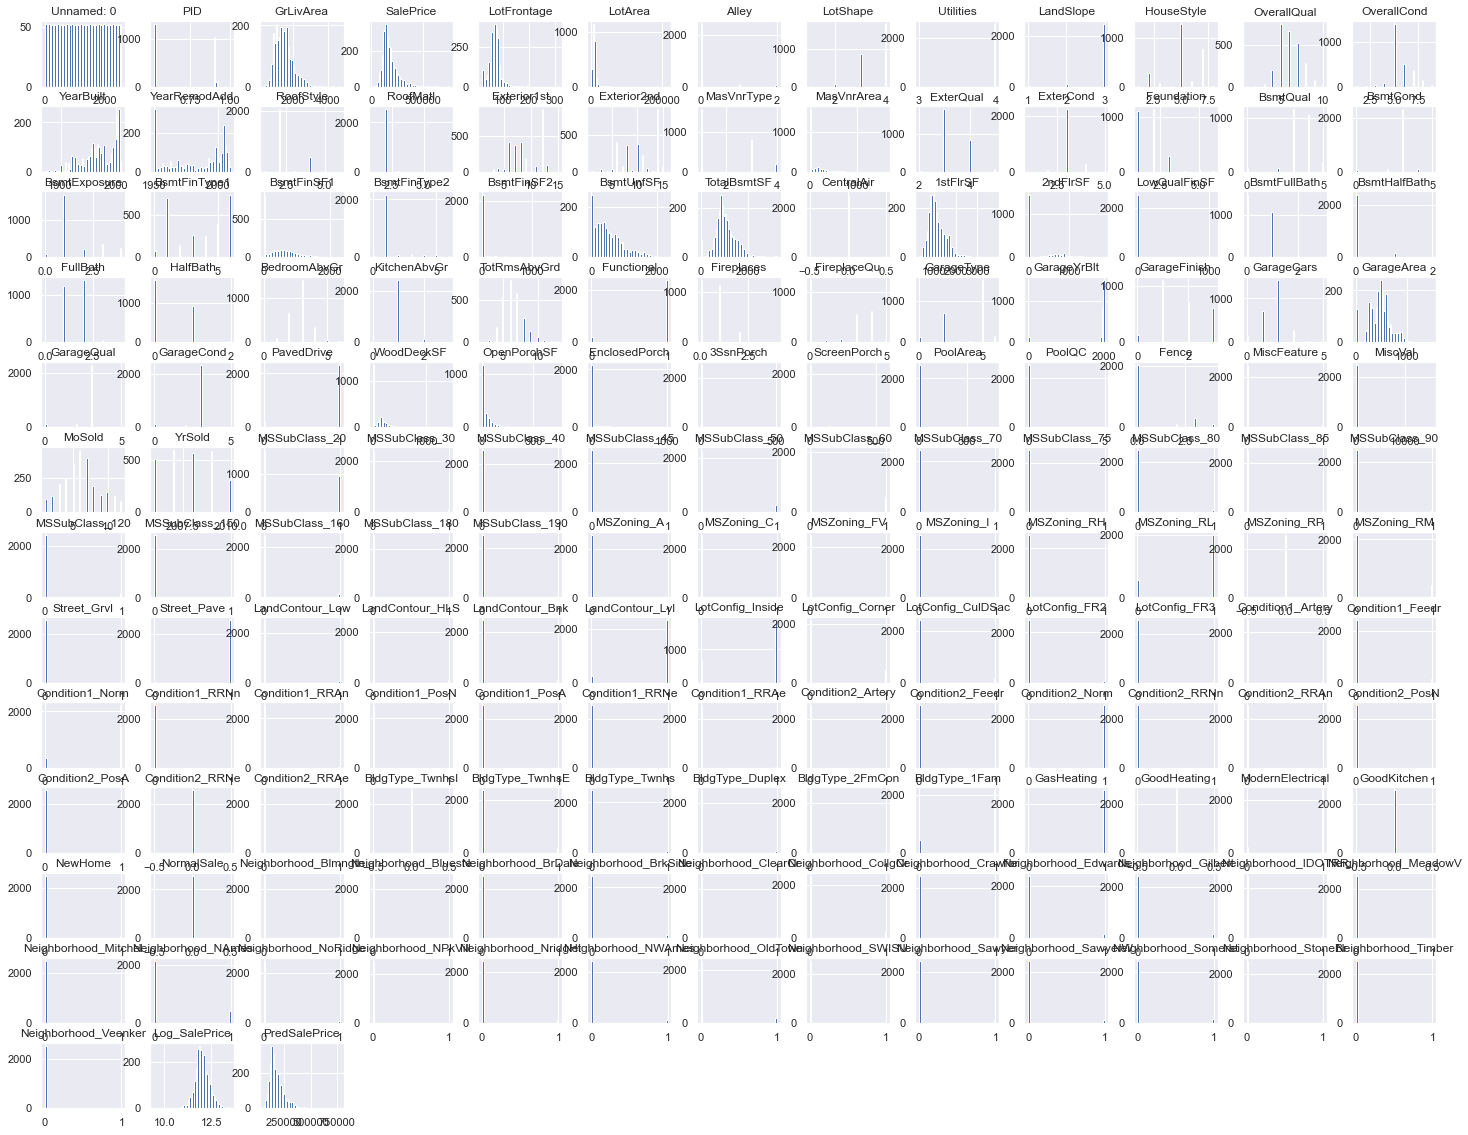

In [128]:
imputedHousingData.hist(bins=50,figsize=(25,20))

In [129]:
def convert_latitude(coordinate):
    return float(str(coordinate).replace("(","").replace(")","").split(",")[0])
def convert_longitude(coordinate):
    if (len(str(coordinate).replace("(","").replace(")","").split(",")))==2:
        return float(str(coordinate).replace("(","").replace(")","").split(",")[1])
    else:
        return 0
def make_point(row):
    return Point(row.longitude, row.latitude)
imputedHousingData_map["latitude"]=imputedHousingData_map['coord'].apply(convert_latitude)
imputedHousingData_map["longitude"]=imputedHousingData_map['coord'].apply(convert_longitude)

In [132]:
cheapest_200_homes=imputedHousingData_map[imputedHousingData_map.SalePrice<=100000]

In [73]:
parknames=parkData[0].tolist()
parklatitudes=parkData[1].tolist()
parklongitudes=parkData[2].tolist()

<AxesSubplot:>

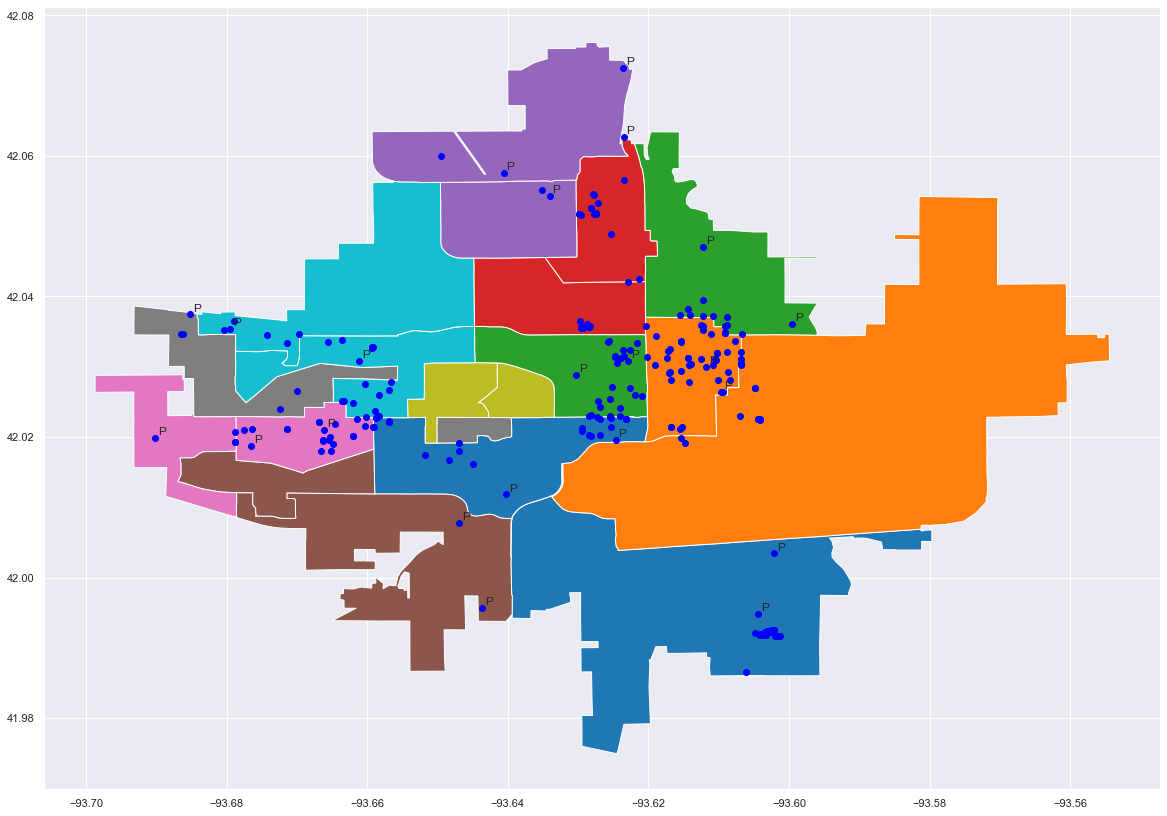

In [133]:
amesPoints = pd.DataFrame({
    'Point':cheapest_200_homes['PID'].tolist()+parknames[0:25],
    'Latitude':cheapest_200_homes['latitude'].tolist()+parklatitudes[0:25],
    'Longitude':cheapest_200_homes['longitude'].tolist()+parklongitudes[0:25]
})
gdf = gp.GeoDataFrame(amesPoints, geometry=gp.points_from_xy(amesPoints.Longitude, amesPoints.Latitude))
ax=df_neighbourhoods.plot(column="NAME", cmap=None,figsize=(20, 20))

for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf.Point):
    if type(label)==str and label.find("Park")>-1:
        ax.annotate("P", xy=(x, y), xytext=(3, 3), textcoords="offset points")
    else:
        ax.annotate("", xy=(x, y), xytext=(3, 3), textcoords="offset points")
gdf.plot(ax=ax,color="blue")


<AxesSubplot:>

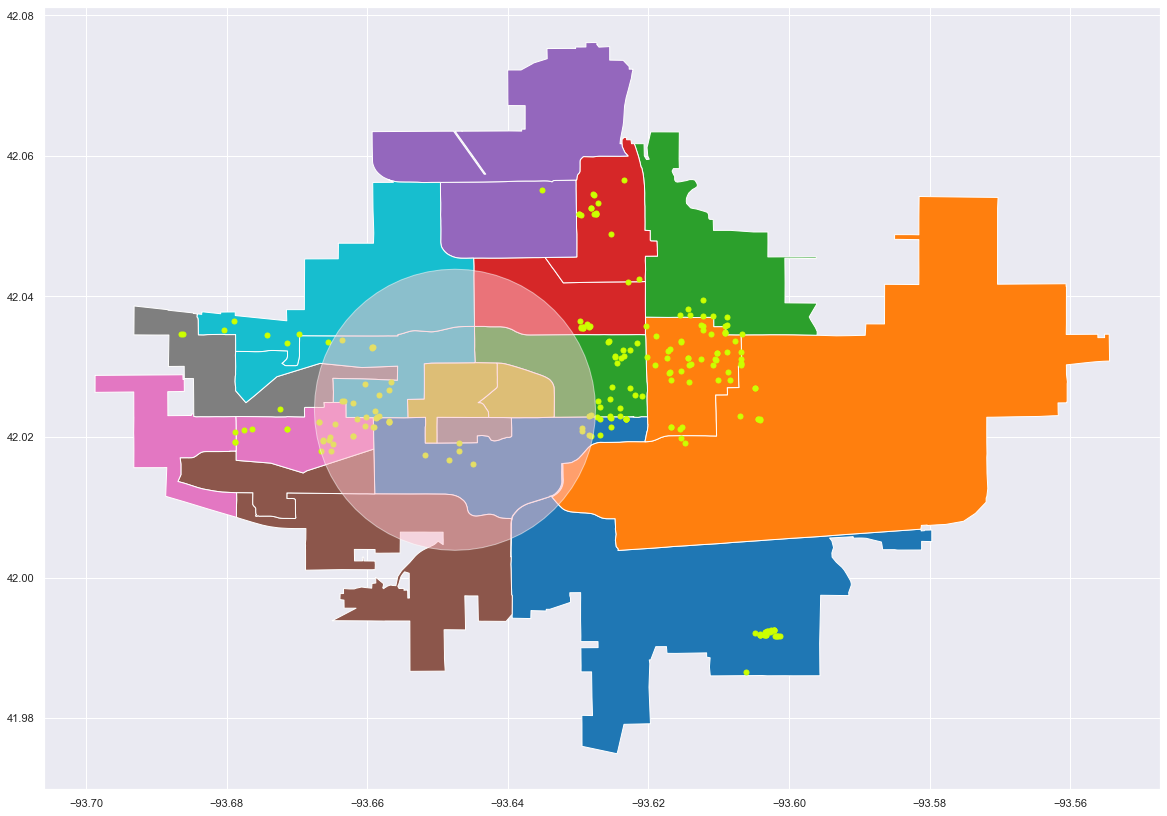

In [140]:
cheap200_points= cheapest_200_homes.apply(make_point, axis=1)
cheap200homes = gp.GeoDataFrame(cheapest_200_homes, geometry=cheap200_points)

uni_coord=pd.DataFrame({'name':['Iowa State University'],'latitude':[42.023949], 'longitude':[-93.647595]})
university_points=uni_coord.apply(make_point,axis=1)
university = gp.GeoDataFrame(uni_coord, geometry=university_points)
for x, y in zip(university.geometry.x, university.geometry.y):
    ax.annotate("Iowa State University", xy=(x, y), xytext=(3, 3), textcoords="offset points")

university['geometry'] = university.geometry.buffer(0.02)
ax.set_axis_off()
ax=df_neighbourhoods.plot(column="NAME", cmap=None,figsize=(20, 20))
cheap200homes.plot(markersize=25, color="#CCFF00",ax=ax)
university.plot(markersize=100, color="pink",ax=ax, alpha=0.5)


In [135]:
#Calculate distance
from geopy.distance import geodesic 
def get_distance(pointa,pointb):
    return geodesic(pointa,pointb).miles
university_coordinates = (uni_coord.loc[0,'latitude'],uni_coord.loc[0,'longitude'])
cheapest_200_homes.loc[:,'distUni']=cheapest_200_homes.apply(lambda x: get_distance((x.latitude, x.longitude),university_coordinates), axis=1)


/Users/chitrasharathchandra/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/chitrasharathchandra/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [136]:
homesforUniHousing=cheapest_200_homes[
    ((cheapest_200_homes['distUni']<=1) & 
     ((cheapest_200_homes['BedroomAbvGr']/cheapest_200_homes['FullBath']<=2) | 
      (((cheapest_200_homes['BsmtFinType1']>=5) | 
        (cheapest_200_homes['BsmtFinType2']>=5) & 
        (cheapest_200_homes["BsmtFullBath"]>=1)))) &
    (cheapest_200_homes['OverallCond'] <= 3) & (cheapest_200_homes['OverallQual']<=3))
]

<AxesSubplot:>

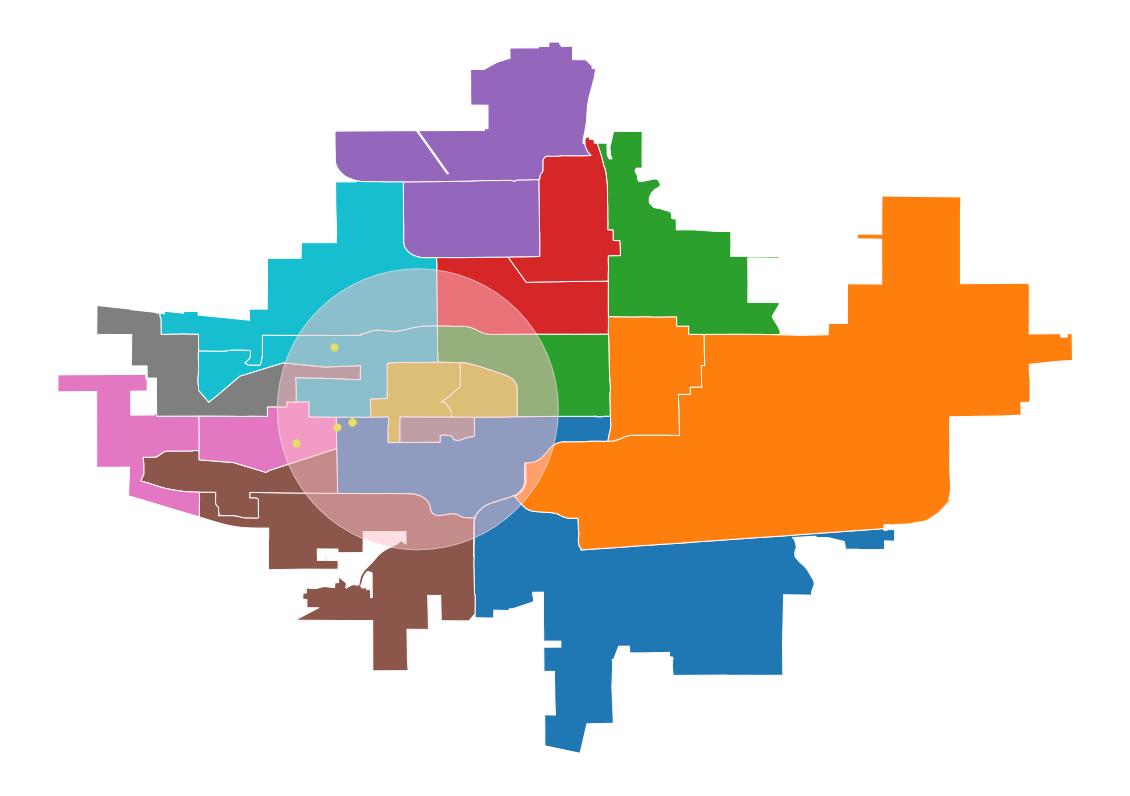

In [137]:
#Map for target homes
homesforUniHousing_points= homesforUniHousing.apply(make_point, axis=1)
homesforUniHousingHomes = gp.GeoDataFrame(homesforUniHousing, geometry=homesforUniHousing_points)

uni_coord=pd.DataFrame({'name':['Iowa State University'],'latitude':[42.023949], 'longitude':[-93.647595]})
university_points=uni_coord.apply(make_point,axis=1)
university = gp.GeoDataFrame(uni_coord, geometry=university_points)
university['geometry'] = university.geometry.buffer(0.02)
ax=df_neighbourhoods.plot(column="NAME", cmap=None,figsize=(20, 20))
ax.set_axis_off()
homesforUniHousingHomes.plot(markersize=50, color="#CCFF00",ax=ax)
university.plot(markersize=100, color="pink",ax=ax, alpha=0.5)